In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# setting seeds for reproducibility
torch.manual_seed(42)

In [3]:
class Expert(nn.Module):
    """A simple Feed-Forward Network representing one expert."""
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )

    def forward(self, x):
        return self.net(x)

In [4]:
class NoisyTopKGater(nn.Module):
    def __init__(self, d_model, num_experts, top_k=2):
        super().__init__()
        self.gate = nn.Linear(d_model, num_experts)
        self.top_k = top_k

    def forward(self, x):
        # x shape: [batch_size, seq_len, d_model]
        logits = self.gate(x)
        
        # add noise to encourage exploration of all experts
        noise = torch.randn_like(logits) * 0.1
        logits = logits + noise

        # get the top-k indices and their weights
        top_k_logits, top_k_indices = torch.topk(logits, self.top_k, dim=-1)
        
        # softmax over the top-k to get routing weights
        weights = F.softmax(top_k_logits, dim=-1)
        
        return weights, top_k_indices

In [5]:
class SparseMoE(nn.Module):
    def __init__(self, d_model, d_ff, num_experts, top_k=2):
        super().__init__()
        self.num_experts = num_experts
        self.top_k = top_k
        self.experts = nn.ModuleList([Expert(d_model, d_ff) for _ in range(num_experts)])
        self.gater = NoisyTopKGater(d_model, num_experts, top_k)

    def forward(self, x):
        batch_size, seq_len, d_model = x.shape
        x_flat = x.view(-1, d_model) # [Total_tokens, d_model]
        
        # get routing weights and expert indices
        weights, indices = self.gater(x) 
        weights = weights.view(-1, self.top_k)
        indices = indices.view(-1, self.top_k)

        final_output = torch.zeros_like(x_flat)

        # loop through experts (In production, this is optimized via grouped GEMM)
        for i, expert in enumerate(self.experts):
            # find tokens assigned to this expert
            mask = (indices == i).any(dim=-1)
            if mask.any():
                token_indices, k_indices = torch.where(indices == i)
                
                # get the weight assigned to this expert for these specific tokens
                expert_weights = weights[token_indices, k_indices].unsqueeze(-1)
                
                # process tokens and apply weight
                expert_out = expert(x_flat[token_indices])
                final_output[token_indices] += expert_weights * expert_out

        return final_output.view(batch_size, seq_len, d_model), indices

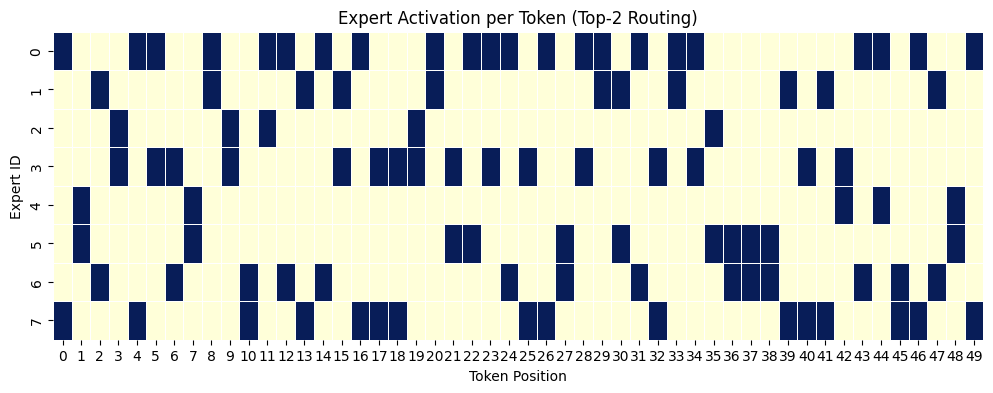

In [6]:
# setup dummy data
d_model, d_ff, num_experts = 16, 64, 8
moe_layer = SparseMoE(d_model, d_ff, num_experts, top_k=2)
dummy_input = torch.randn(1, 50, d_model) # 50 tokens

# forward pass
output, routing_indices = moe_layer(dummy_input)

# prepare visualization data
routing_data = routing_indices.squeeze(0).numpy()
heatmap_array = np.zeros((num_experts, 50))

for token_idx, experts in enumerate(routing_data):
    for e in experts:
        heatmap_array[e, token_idx] = 1

plt.figure(figsize=(12, 4))
sns.heatmap(heatmap_array, cmap="YlGnBu", cbar=False, linewidths=.5)
plt.title("Expert Activation per Token (Top-2 Routing)")
plt.xlabel("Token Position")
plt.ylabel("Expert ID")
plt.show()